## Telecom_Data analysis

### Project Decomposition

**Project Description:**
The commercial director of the telecommunications company "NuPozvoni" asked us to perform a data analysis. Due to the potential market entry of a competitor with more favorable tariffs, he asked us to analyze data about corporate clients and how they use their tariffs. The goal is to identify active clients who do not use their tariffs optimally and propose them more appropriate tariffs to retain them, preventing them from switching to the competitor, without significantly reducing our company's revenue.

**Project Objective:**
The objective of the project is to identify clients who do not use their tariffs optimally and find alternative tariffs that can increase their loyalty and reduce the likelihood of them churning, while also minimizing the impact on the company's revenue.

**Tasks (Subtasks):**

- Calculate the expenses for all clients.
- Identify active clients.
- Identify active clients who are using their tariffs suboptimally (overpaying).
- Determine which optimal tariffs can be offered to these clients.
- Assess the impact on our revenue.
- Find ways to minimize losses (evaluate results and provide recommendations).

**Results:**

- Research conducted in a Jupyter notebook.
- File containing a list of users who are using their tariffs suboptimally.
- Dashboard presenting the findings.
- Presentation with the research results.

The task is to conduct an analysis of two datasets that characterize the usage of services by "NuPozvoni." The analysis needs to be performed periodically every 3 months, so the code should be written to be universal and consider a three-month research range.

**Dataset telecom_dataset.csv:**
- `user_id`: client identifier
- `date`: date
- `direction`: call direction (out — outgoing call, in — incoming call)
- `internal`: marker for internal and external calls; calls between employees of the same call center are considered internal, others are considered external.
- `operator_id`: operator identifier
- `is_missed_call`: marker for missed calls
- `calls_count`: number of calls
- `call_duration`: duration of all calls excluding wait time
- `total_call_duration`: duration of all calls including wait time

**Dataset telecom_clients.csv:**
- `user_id`: client identifier
- `tariff_plan`: client's tariff plan
- `date_start`: client's registration date in the service

The following tariff plans are available in the Telecom:

| Tariff Plan | Monthly Fee | Incoming Calls | Outgoing Calls* within network** | Internal Outgoing Limit | External Outgoing Calls | Operator Fee per Operator |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| A | 4,000 ₽ | 0 | 0.10 ₽/min. | 2,000 | 0.3 ₽/min. | 50 ₽/operator |
| B | 2,000 ₽ | 0 | 0.15 ₽/min. | 500 | 0.5 ₽/min. | 150 ₽/operator |
| C | 1,000 ₽ | 0 | 0.30 ₽/min. | 0 | 0.7 ₽/min. | 300 ₽/operator |

\* outgoing calls including wait time;
\** some tariffs have a free limit for outgoing calls within the network, up to a certain number of minutes (see tariff plan); the price is given for usage beyond the established limit.



**Research Process:**

1. Project Decomposition
2. Data Description
3. Data Loading and Exploration
4. Data Preprocessing:
   - Converting data to the required format
   - Handling outliers, missing values, and duplicates
5. Exploratory Data Analysis:
   - Identifying active clients
   - Calculating total revenue
   - Identifying clients with suboptimal tariff usage
   - Selecting the optimal tariff
   - Assessing revenue changes after selecting the optimal tariff
6. Statistical Data Analysis:
   - Hypothesis 1: Revenue difference before and after switching tariffs
   - Hypothesis 2: Revenue difference between clients of tariff plans A and B
7. Conclusions
8. Presentation



## Data loading and exploration

In [1]:
import pandas as pd
import numpy as np
import math
from scipy import stats as st
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import seaborn as sns 
from numpy import median
import re
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
cm = sns.light_palette("red", as_cmap=True)

In [2]:
try:
    calls = pd.read_csv('telecom_dataset.csv')
    clients = pd.read_csv('telecom_clients.csv')
except:
    calls = pd.read_csv('https://code.s3.yandex.net/datasets/telecom_dataset.csv')
    clients = pd.read_csv('https://code.s3.yandex.net/datasets/telecom_clients.csv')
    

In [3]:
calls.head(5)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


<AxesSubplot:>

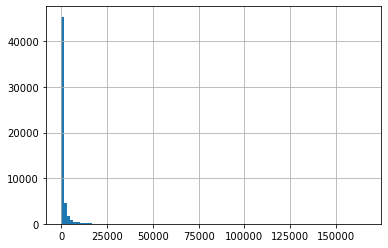

In [5]:
calls['total_call_duration'].hist(bins = 100)

In [6]:
calls['total_call_duration'].max()*60

9969300

In [7]:
print(f"Total duplicates {calls.duplicated().sum()}.") 

Total duplicates 4900.


In [8]:
print(f"Total duplicates {clients.duplicated().sum()}.") 

Total duplicates 0.


In [9]:
def null_info(df):
    null_values = df.isna().sum().reset_index()
    null_values = null_values.rename(columns = {0:'isna'})
    null_values = null_values[null_values['isna'] != 0].reset_index(drop = True)
    null_values['percentage'] = round(null_values['isna']/len(df)*100,2)
    if len(null_values) != 0: 
        for index,row in null_values.iterrows():
            print(f"Number of missing values {row['index']} is {row['isna']}, which is {row['percentage']}% of the total")
    else: 
        print(f"No missing values")
    

In [10]:
null_info(calls)

Number of missing values internal is 117, which is 0.22% of the total
Number of missing values operator_id is 8172, which is 15.16% of the total


In [11]:
null_info(clients)

No missing values


## Data preprocessing

In [12]:
#Converting data to the required format
calls['date'] = pd.to_datetime(calls['date'], format='%Y.%m.%d')
clients['date_start'] = pd.to_datetime(clients['date_start'], format='%Y.%m.%d')

In [13]:
calls['month'] = calls['date'].dt.month

In [14]:
#getting rid of duplicates
calls = calls.drop_duplicates().reset_index(drop = True)

In [15]:
#tarification should be estimated in minutes
calls['call_duration'] = np.ceil(calls['call_duration']/60)
calls['total_call_duration'] = np.ceil(calls['total_call_duration']/60)

In [16]:
#checking outliers
calls.describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration,month
count,49002.000000,41546.000000,49002.000000,49002.000000,49002.000000,49002.000000
mean,167294.892759,916523.315409,16.462777,14.726930,19.791621,10.192380
std,598.558965,21230.041008,63.604098,62.970904,74.185227,0.852065
min,166377.000000,879896.000000,1.000000,0.000000,0.000000,8.000000
25%,166782.000000,900790.500000,1.000000,0.000000,1.000000,10.000000
50%,167158.000000,913938.000000,4.000000,1.000000,4.000000,10.000000
75%,167819.000000,937708.000000,12.000000,10.000000,16.000000,11.000000
max,168606.000000,973286.000000,4817.000000,2407.000000,2770.000000,11.000000


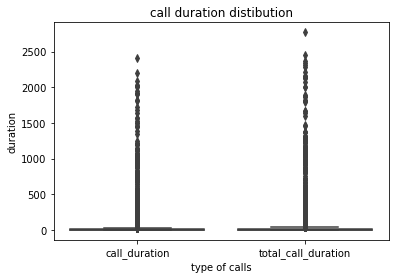

In [17]:
sns.boxplot(data = calls[['call_duration','total_call_duration']])
plt.title ('call duration distibution')
plt.xlabel ('type of calls')
plt.ylabel ('duration');

Text(0, 0.5, 'duration')

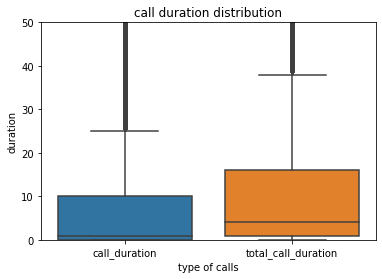

In [18]:
sns.boxplot(data = calls[['call_duration','total_call_duration']])
plt.ylim(0,50)
plt.title ('call duration distribution')
plt.xlabel ('type of calls')
plt.ylabel ('duration')

In columns with call duration, there are outliers, as the median significantly differs from the 75th percentile and the mean. Let's find abnormally long calls. We'll attempt to identify outliers and explore their nature.

,date,operator_id,call_duration,total_call_duration
0,2019-09-25 00:00:00+03:00,885876.0,2407.0,3155.0
1,2019-09-26 00:00:00+03:00,885876.0,2204.0,2782.0
2,2019-09-09 00:00:00+03:00,885876.0,2019.0,2652.0
3,2019-09-18 00:00:00+03:00,885876.0,2028.0,2651.0
4,2019-10-02 00:00:00+03:00,885876.0,2003.0,2556.0


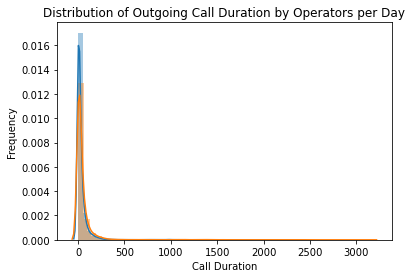

In [19]:
anomal_calls = calls.query('direction == "out"')
anomal_calls = anomal_calls.groupby(['date','operator_id']).agg({'call_duration':'sum','total_call_duration':'sum'}).sort_values('total_call_duration', ascending = False).reset_index()
display(anomal_calls.head(5))
sns.distplot(anomal_calls['call_duration'])
sns.distplot(anomal_calls['total_call_duration']).set(title = 'Distribution of Outgoing Call Duration by Operators per Day',
                                                xlabel = 'Call Duration',
                                                ylabel = 'Frequency');


In [20]:
anomal_calls = anomal_calls.query('total_call_duration > 720')
display(anomal_calls.describe())
print(f"The total call duration of anomalously active operators is {anomal_calls['total_call_duration'].sum()}, while the total call duration for the entire period under consideration is {calls['total_call_duration'].sum()}. Therefore, if we remove calls from anomalously active operators, we will lose {round(anomal_calls['total_call_duration'].sum() / calls['total_call_duration'].sum() * 100, 2)}% of the total duration.")


,operator_id,call_duration,total_call_duration
count,123.000000,123.000000,123.000000
mean,892355.642276,1014.780488,1419.113821
std,15025.194725,443.368783,524.954240
min,885876.000000,45.000000,725.000000
25%,885876.000000,740.000000,1111.500000
50%,885890.000000,926.000000,1298.000000
75%,885890.000000,1138.000000,1553.000000
max,945278.000000,2407.000000,3155.000000


The total call duration of anomalously active operators is 174551.0, while the total call duration for the entire period under consideration is 969829.0. Therefore, if we remove calls from anomalously active operators, we will lose 18.0% of the total duration.


We found data about anomalously long calls made by operators, which they couldn't physically accomplish based on the assumption that an operator's maximum working time is 12 hours per day. However, if we remove these calls, it will significantly reduce our revenue.

It is likely that these are billing errors that need to be reported to the employer later. However, since we are currently analyzing actual customer expenses, I suggest not removing these outliers from the dataset.

In [21]:
operators_isna = calls[calls['operator_id'].isna()]
operators_isna.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,month
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0.0,1.0,8
7,166377,2019-08-05 00:00:00+03:00,in,False,NaN,True,6,0.0,1.0,8
8,166377,2019-08-06 00:00:00+03:00,in,False,NaN,True,4,0.0,2.0,8
16,166377,2019-08-07 00:00:00+03:00,in,False,NaN,True,2,0.0,1.0,8
26,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0.0,1.0,8


In [22]:
operators_isna.describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration,month
count,7456.000000,0.0,7456.000000,7456.000000,7456.000000,7456.000000
mean,167259.123793,NaN,14.024142,1.120842,4.540236,10.088653
std,586.842979,NaN,81.785240,15.796128,21.076476,0.887381
min,166377.000000,NaN,1.000000,0.000000,0.000000,8.000000
25%,166782.000000,NaN,1.000000,0.000000,1.000000,10.000000
50%,167125.000000,NaN,2.000000,0.000000,1.000000,10.000000
75%,167727.000000,NaN,7.000000,0.000000,2.000000,11.000000
max,168606.000000,NaN,2168.000000,437.000000,712.000000,11.000000


In [23]:
display(operators_isna.query('direction == "out"')['total_call_duration'].sum())
round(operators_isna.query('direction == "out"')['total_call_duration'].sum()/calls['total_call_duration'].sum()*100,2)

3083.0

0.32

The percentage of tariffed calls in the rows with missing operators is very small, so we can get rid of the missing values, and it will not affect the analysis.

In [24]:
internal_isna = calls[calls['internal'].isna()]
internal_isna.groupby('direction').agg({'calls_count':'sum'})

,calls_count
direction,
in,219
out,6


The missing values in the "internal" column are mostly incoming calls, indicating that they do not affect the tariffication. Therefore, we can safely remove them.

In [25]:
calls = calls.dropna()

## Exploratory data analysis

creating a dataframe with tariffs

In [26]:
tariffs = pd.DataFrame(
    {
        'tariff_plan': ['A', 'B', 'C'],
        'price_month': [4000, 2000, 1000],
        'calls_internal': [0.1, 0.15, 0.3],
        'calls_external': [0.3, 0.5, 0.7],
        'internal_limit': [2000, 500, 0],
        'operator_cost' : [50, 150, 300]
    }
)

In [27]:
display(calls['date'].min())
calls['date'].max()

Timestamp('2019-08-02 00:00:00+0300', tz='pytz.FixedOffset(180)')

Timestamp('2019-11-28 00:00:00+0300', tz='pytz.FixedOffset(180)')

The dataset displays data from August 2, 2019, to November 28, 2019 (4 months), while according to the analysis task conditions, we should consider data only for the last three months.

In [28]:
calls = calls[calls['month'] > (calls['month'].max() - 3)] 

In [29]:
clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


Considering that customers are billed in full for the month they subscribed, we can specify the month of their subscription to understand from which point we should calculate their payment.

In [30]:
clients['month_start'] = clients['date_start'].dt.month
clients['month_start_name'] = clients['date_start'].dt.strftime('%B')

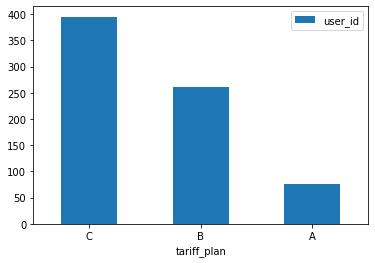

In [31]:
clients.groupby('tariff_plan').agg({'user_id':'count'}).sort_values('user_id', ascending = False).plot(kind = 'bar')
plt.xticks(rotation=0);

The most popular tariff is tariff C, as it is the cheapest, while tariff B is in second place, and tariff A is in the last position.

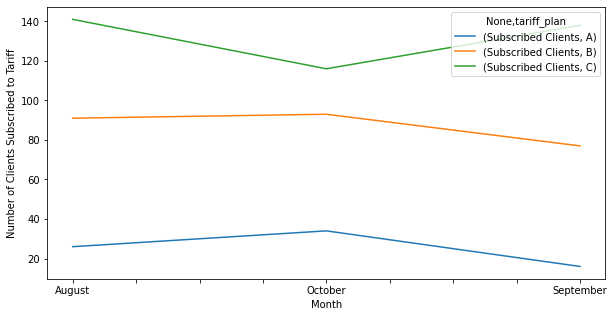

In [32]:
clients.groupby(['month_start_name', 'tariff_plan']).agg({'user_id': 'nunique'}).rename(columns={'user_id': 'Subscribed Clients'}).unstack().plot(figsize=(10, 5))
plt.xlabel('Month')
plt.ylabel('Number of Clients Subscribed to Tariff');

In October, there was a certain trend where the number of customers subscribed to tariff C decreased, while the number of customers for tariffs A and B slightly increased. However, overall, customers tended to prefer tariff C, as it remained the most popular choice throughout the observed period.

In [33]:
clients['current_date'] = calls['date'].max()
clients['total_months'] = clients['current_date'].dt.to_period('M').astype(int) - \
    clients['date_start'].dt.to_period('M').astype(int)


In [34]:
df = calls.merge(clients, on='user_id')

In [35]:
clients['user_id'].nunique()

732

In [36]:
df['user_id'].nunique()

286

Evidently, the table with clients contains more entries than the table with calls, indicating that the table with clients likely includes data about all the customers of the telecom company "NuPozvoni."

,user_id,month,total_call_duration
0,166377,3,1718.000000
1,166405,3,5117.666667
2,166406,3,1529.666667
3,166407,3,140.666667
4,166485,3,2478.333333
...,...,...,...
213,168481,1,11.000000
214,168500,1,1.000000
215,168601,1,572.000000
216,168603,1,23.000000


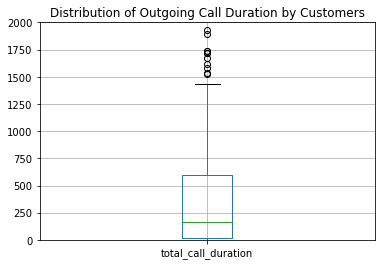

count    218.000000  
mean     1416.013761 
std      5665.909516 
min      0.000000    
25%      21.500000   
50%      161.416667  
75%      595.583333  
max      53897.666667
Name: total_call_duration, dtype: float64

In [37]:
# Determine who can be considered as active customers.
# Examine the distribution of billed calls during the considered period.
total_out_calls = calls.query('direction == "out" & internal == False').groupby(['user_id', 'month']).agg({'total_call_duration': 'sum'}).reset_index()
total_out_calls_mean = total_out_calls.groupby('user_id').agg({'month': 'count', 'total_call_duration': 'mean'}).reset_index()
display(total_out_calls_mean)
total_out_calls_mean.boxplot(column='total_call_duration')
plt.ylim(0, 2000)
plt.title('Distribution of Outgoing Call Duration by Customers')
plt.show()
total_out_calls_mean['total_call_duration'].describe()


Given the low position of the 1st quartile on the boxplot, I propose to consider those who are not within the 1st quartile but used the services for more than 1 month as inactive customers.

In [38]:
inactive_clients_threshold = total_out_calls_mean['total_call_duration'].describe()[4]
active_clients = total_out_calls_mean.query('month > 1 & total_call_duration > @inactive_clients_threshold')
print(f'Total number of clients = {df["user_id"].nunique()}, while the number of active clients = {active_clients["user_id"].nunique()}')


Total number of clients = 286, while the number of active clients = 137


In [39]:
#leave the list with active clients for further analysis
active_clients_list = active_clients['user_id'].unique()

Calculate the revenue for all customers

In [40]:
tariffs

,tariff_plan,price_month,calls_internal,calls_external,internal_limit,operator_cost
0,A,4000,0.10,0.3,2000,50
1,B,2000,0.15,0.5,500,150
2,C,1000,0.30,0.7,0,300


In [41]:
total_ext_minutes = df.query('direction == "out" and internal == False').groupby(['user_id','month','tariff_plan']).agg({'total_call_duration':'sum'}).reset_index().rename(columns = {'total_call_duration':'total_ext_minutes'})
total_int_minutes = df.query('direction == "out" and internal == True').groupby(['user_id','month']).agg({'total_call_duration':'sum'}).reset_index().rename(columns = {'total_call_duration':'total_int_minutes'})

revenue_df = total_ext_minutes.merge(total_int_minutes, how = 'left', on =  ['user_id','month'])


In [42]:
unique_operators_per_month = df.groupby(['user_id','month','tariff_plan'])['operator_id'].nunique().reset_index().rename(columns = {'operator_id':'total_operators'})
revenue_df = revenue_df.merge(unique_operators_per_month, how = 'right', on = ['user_id','month','tariff_plan'])

In [43]:
revenue_df = revenue_df.fillna(0)

In [44]:
def calculate_revenue(revenue_df, tariffs):
    for i, row in tariffs.iterrows():
        tariff_name = row['tariff_plan']
        calls_external = row['calls_external']
        operator_cost = row['operator_cost']
        price_month = row['price_month']
        internal_limit = row['internal_limit']
        calls_internal = row['calls_internal']
        
        revenue_df[f'tariff_{tariff_name}'] = revenue_df['total_ext_minutes']*calls_external \
                                            + revenue_df['total_operators']*operator_cost \
                                            + price_month

        def int_calls(row):
            if row['total_ext_minutes'] > internal_limit:
                return row[f'tariff_{tariff_name}'] + ((row['total_ext_minutes'] - internal_limit)*calls_internal)
            else:
                return row[f'tariff_{tariff_name}']

        revenue_df[f'tariff_{tariff_name}'] = revenue_df.apply(int_calls, axis=1)

    return revenue_df

In [45]:
revenue_df = calculate_revenue(revenue_df, tariffs)

In [46]:
revenue_df

,user_id,month,tariff_plan,total_ext_minutes,total_int_minutes,total_operators,tariff_A,tariff_B,tariff_C
0,166377,9,B,1818.0,5.0,4,4745.4,3706.7,4018.0
1,166377,10,B,1704.0,2.0,5,4761.2,3782.6,4204.0
2,166377,11,B,1632.0,4.0,4,4689.6,3585.8,3832.0
3,166391,9,C,0.0,0.0,1,4050.0,2150.0,1300.0
4,166391,11,C,0.0,0.0,1,4050.0,2150.0,1300.0
...,...,...,...,...,...,...,...,...,...
626,168583,11,B,0.0,0.0,2,4100.0,2300.0,1600.0
627,168598,11,C,0.0,0.0,1,4050.0,2150.0,1300.0
628,168601,11,C,572.0,0.0,2,4271.6,2596.8,2172.0
629,168603,11,B,23.0,0.0,1,4056.9,2161.5,1323.0


In [47]:
def current_tariff_profit(row):
    for i,x in tariffs.iterrows():
        tariff_name = x['tariff_plan']
        if row['tariff_plan'] == tariff_name:
            return row[f'tariff_{tariff_name}']

revenue_df['current_tariff_profit'] = revenue_df.apply(current_tariff_profit,axis = 1)
revenue_df

,user_id,month,tariff_plan,total_ext_minutes,total_int_minutes,total_operators,tariff_A,tariff_B,tariff_C,current_tariff_profit
0,166377,9,B,1818.0,5.0,4,4745.4,3706.7,4018.0,3706.7
1,166377,10,B,1704.0,2.0,5,4761.2,3782.6,4204.0,3782.6
2,166377,11,B,1632.0,4.0,4,4689.6,3585.8,3832.0,3585.8
3,166391,9,C,0.0,0.0,1,4050.0,2150.0,1300.0,1300.0
4,166391,11,C,0.0,0.0,1,4050.0,2150.0,1300.0,1300.0
...,...,...,...,...,...,...,...,...,...,...
626,168583,11,B,0.0,0.0,2,4100.0,2300.0,1600.0,2300.0
627,168598,11,C,0.0,0.0,1,4050.0,2150.0,1300.0,1300.0
628,168601,11,C,572.0,0.0,2,4271.6,2596.8,2172.0,2172.0
629,168603,11,B,23.0,0.0,1,4056.9,2161.5,1323.0,2161.5


Let's determine the most optimal tariff plan for the customer.

In [48]:
revenue_df['best_tariff_plan'] = revenue_df[['tariff_A', 'tariff_B', 'tariff_C']].idxmin(axis=1)


In [49]:
revenue_df['best_tariff_plan'] = revenue_df['best_tariff_plan'].replace('tariff_A', 'A')
revenue_df['best_tariff_plan'] = revenue_df['best_tariff_plan'].replace('tariff_B', 'B')
revenue_df['best_tariff_plan'] = revenue_df['best_tariff_plan'].replace('tariff_C', 'C')

In [50]:
def best_tariff_profit(row):
    for i,x in tariffs.iterrows():
        tariff_name = x['tariff_plan']
        if row['best_tariff_plan'] == tariff_name:
            return row[f'tariff_{tariff_name}']

revenue_df['best_tariff_profit'] = revenue_df.apply(best_tariff_profit,axis = 1)
revenue_df

,user_id,month,tariff_plan,total_ext_minutes,total_int_minutes,total_operators,tariff_A,tariff_B,tariff_C,current_tariff_profit,best_tariff_plan,best_tariff_profit
0,166377,9,B,1818.0,5.0,4,4745.4,3706.7,4018.0,3706.7,B,3706.7
1,166377,10,B,1704.0,2.0,5,4761.2,3782.6,4204.0,3782.6,B,3782.6
2,166377,11,B,1632.0,4.0,4,4689.6,3585.8,3832.0,3585.8,B,3585.8
3,166391,9,C,0.0,0.0,1,4050.0,2150.0,1300.0,1300.0,C,1300.0
4,166391,11,C,0.0,0.0,1,4050.0,2150.0,1300.0,1300.0,C,1300.0
...,...,...,...,...,...,...,...,...,...,...,...,...
626,168583,11,B,0.0,0.0,2,4100.0,2300.0,1600.0,2300.0,C,1600.0
627,168598,11,C,0.0,0.0,1,4050.0,2150.0,1300.0,1300.0,C,1300.0
628,168601,11,C,572.0,0.0,2,4271.6,2596.8,2172.0,2172.0,C,2172.0
629,168603,11,B,23.0,0.0,1,4056.9,2161.5,1323.0,2161.5,C,1323.0


We have created a table with all possible tariffs for each user, as well as their current and most optimal tariff plan.

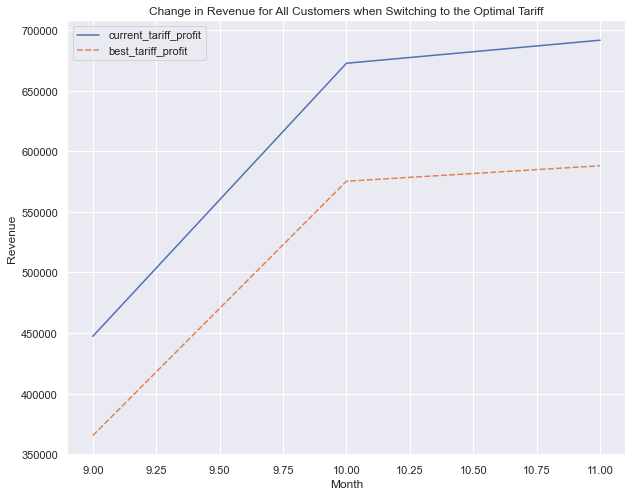

In [51]:
months_revenue = revenue_df.groupby('month').agg({'current_tariff_profit': 'sum', 'best_tariff_profit': 'sum'})
sns.set(rc={'figure.figsize':(10, 8)})
sns.lineplot(data=months_revenue).set(title='Change in Revenue for All Customers when Switching to the Optimal Tariff',
                                      xlabel='Month',
                                      ylabel='Revenue');



Let's see how much revenue is being lost

In [52]:
months_revenue['loss'] = months_revenue['current_tariff_profit'] - months_revenue['best_tariff_profit']
print(f'Total revenue loss will be {round(months_revenue["loss"].sum())}, which is {round(months_revenue["loss"].sum() / months_revenue["current_tariff_profit"].sum() * 100, 2)}% of the total revenue')


Total revenue loss will be 282814, which is 15.61% of the total revenue


Let's perform the same calculations for active clients only

In [53]:
active_revenue_df = revenue_df.query('user_id in @active_clients_list')

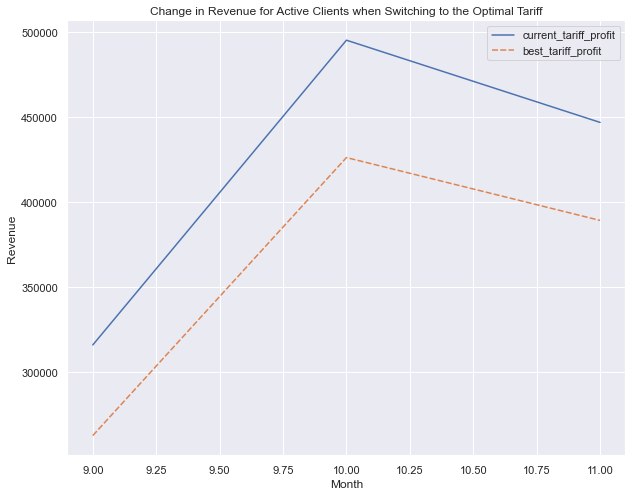

In [54]:
months_revenue_active = active_revenue_df.groupby('month').agg({'current_tariff_profit': 'sum', 'best_tariff_profit': 'sum'})
sns.set(rc={'figure.figsize': (10, 8)})
sns.lineplot(data=months_revenue_active).set(title='Change in Revenue for Active Clients when Switching to the Optimal Tariff',
                                            xlabel='Month',
                                            ylabel='Revenue');


In [55]:
months_revenue_active['loss'] = months_revenue_active['current_tariff_profit'] - months_revenue_active['best_tariff_profit']
print(f'Total revenue loss for active clients will be {round(months_revenue_active["loss"].sum())}, which is {round(months_revenue_active["loss"].sum() / months_revenue_active["current_tariff_profit"].sum() * 100, 2)}% of the total revenue for active clients')


Total revenue loss for active clients will be 180222, which is 14.32% of the total revenue for active clients


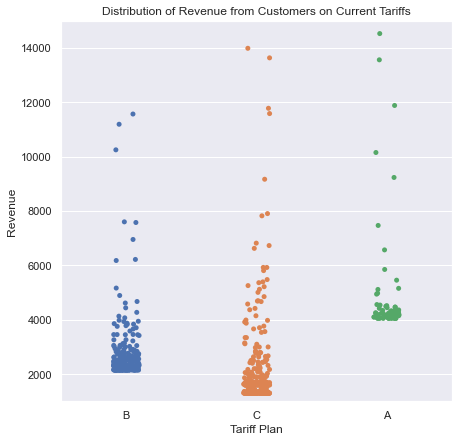

In [56]:
plt.figure(figsize=(7, 7))
ax = sns.stripplot(data=revenue_df, x='tariff_plan', y="current_tariff_profit")
ax.set(title='Distribution of Revenue from Customers on Current Tariffs', ylabel='Revenue', xlabel='Tariff Plan', ylim=(1000, 15000))
plt.show()


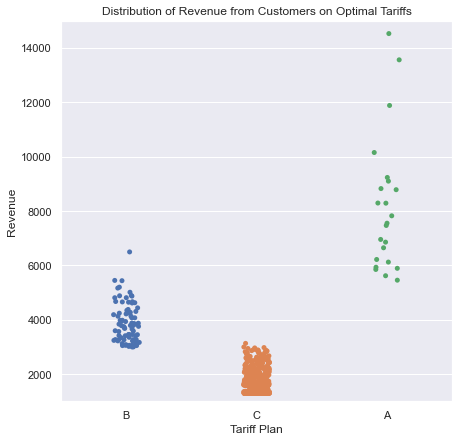

In [57]:
plt.figure(figsize=(7, 7))
ax = sns.stripplot(data=revenue_df, x='best_tariff_plan', y="best_tariff_profit")
ax.set(title='Distribution of Revenue from Customers on Optimal Tariffs', ylabel='Revenue', xlabel='Tariff Plan', ylim=(1000, 15000))
plt.show()


It is evident that the transition to optimal tariffs reduces outliers for tariff plans B and C, but it is necessary to analyze client migration.

In [58]:
aggregated_revenue = revenue_df.groupby(['user_id','tariff_plan']).agg({'tariff_A':'sum',
                                                  'tariff_B':'sum',
                                                  'tariff_C':'sum'}).reset_index()

aggregated_revenue['best_tariff_plan'] = aggregated_revenue[['tariff_A', 'tariff_B', 'tariff_C']].idxmin(axis=1)

aggregated_revenue['best_tariff_plan'] = aggregated_revenue['best_tariff_plan'].replace('tariff_A', 'A')
aggregated_revenue['best_tariff_plan'] = aggregated_revenue['best_tariff_plan'].replace('tariff_B', 'B')
aggregated_revenue['best_tariff_plan'] = aggregated_revenue['best_tariff_plan'].replace('tariff_C', 'C')
aggregated_revenue

,user_id,tariff_plan,tariff_A,tariff_B,tariff_C,best_tariff_plan
0,166377,B,14196.2,11075.10,12054.0,B
1,166391,C,8100.0,4300.00,2600.0,C
2,166392,C,12300.0,6900.00,4800.0,C
3,166399,C,8100.0,4300.00,2600.0,C
4,166405,B,18641.2,19054.45,24953.0,A
...,...,...,...,...,...,...
281,168583,B,8150.0,4450.00,2900.0,C
282,168598,C,4050.0,2150.00,1300.0,C
283,168601,C,4271.6,2596.80,2172.0,C
284,168603,B,4056.9,2161.50,1323.0,C


In [59]:
def recommendation(row):
    dict_params = {'A':3,'B':2, 'C':1}
    dict_params_down = dict(reversed(item) for item in dict_params.items())
    current_tariff = dict_params[row['tariff_plan']]
    if row['tariff_plan'] == row['best_tariff_plan'] :
        return 'optimal'
    else:
        best_tariff = dict_params[str(row['best_tariff_plan'])]
        if current_tariff > best_tariff:
            return 'down_'+ dict_params_down[best_tariff]
        else:
            return 'up_'+ dict_params_down[best_tariff]

In [60]:
aggregated_revenue['recommendation'] = aggregated_revenue.apply(recommendation,axis = 1)
aggregated_revenue

,user_id,tariff_plan,tariff_A,tariff_B,tariff_C,best_tariff_plan,recommendation
0,166377,B,14196.2,11075.10,12054.0,B,optimal
1,166391,C,8100.0,4300.00,2600.0,C,optimal
2,166392,C,12300.0,6900.00,4800.0,C,optimal
3,166399,C,8100.0,4300.00,2600.0,C,optimal
4,166405,B,18641.2,19054.45,24953.0,A,up_A
...,...,...,...,...,...,...,...
281,168583,B,8150.0,4450.00,2900.0,C,down_C
282,168598,C,4050.0,2150.00,1300.0,C,optimal
283,168601,C,4271.6,2596.80,2172.0,C,optimal
284,168603,B,4056.9,2161.50,1323.0,C,down_C


In [61]:
migration = aggregated_revenue.groupby('recommendation').agg({'user_id':'count'}).sort_values(by = 'user_id', ascending = False).rename(columns = {'user_id':'count'})
migration

,count
recommendation,
optimal,158
down_C,102
up_B,13
up_A,8
down_B,5


In [62]:
aggregated_revenue['current_tariff_profit'] = aggregated_revenue.apply(current_tariff_profit, axis=1)
aggregated_revenue['best_tariff_profit'] = aggregated_revenue.apply(best_tariff_profit, axis=1)
print(f"Total revenue for all clients: {aggregated_revenue['current_tariff_profit'].sum():.2f}")
print(f"Revenue decrease: {(aggregated_revenue['current_tariff_profit'].sum() - aggregated_revenue['best_tariff_profit'].sum()):.2f}")
print(f"Revenue decrease percentage: {1 - (aggregated_revenue['best_tariff_profit'].sum() / aggregated_revenue['current_tariff_profit'].sum()):.2f}")


Total revenue for all clients: 1811629.70
Revenue decrease: 270326.30
Revenue decrease percentage: 0.15


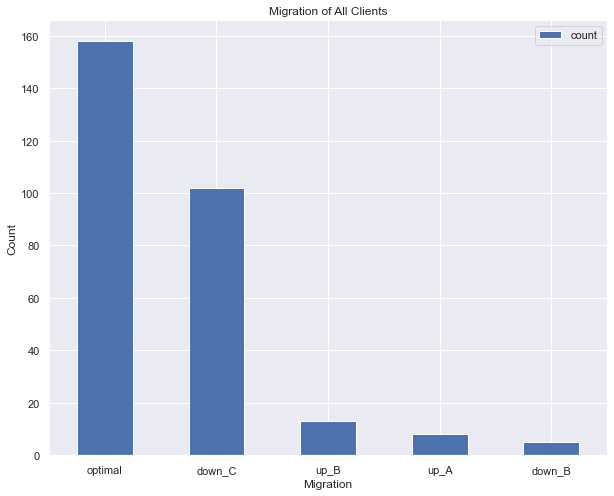

In [63]:
migration.plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Migration of All Clients')
plt.xlabel('Migration')
plt.ylabel('Count')
plt.show()


It is evident that most of clients should downlevel to tarriff C.

In [64]:
active_aggregated_revenue = aggregated_revenue.query('user_id in @active_clients_list')
active_migration = active_aggregated_revenue.groupby('recommendation').agg({'user_id':'count'}).sort_values(by = 'user_id', ascending = False).rename(columns = {'user_id':'count'})
active_migration

,count
recommendation,
optimal,63
down_C,53
up_B,12
down_B,5
up_A,4


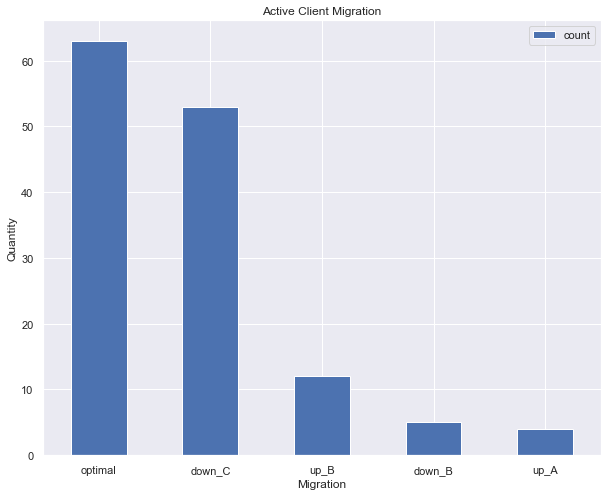

In [65]:
active_migration.plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Active Client Migration')
plt.xlabel('Migration') 
plt.ylabel('Quantity')
plt.show()


For active customers, the transition ratio to tariff C is approximately the same. Let's calculate the decrease in aggregated revenue.

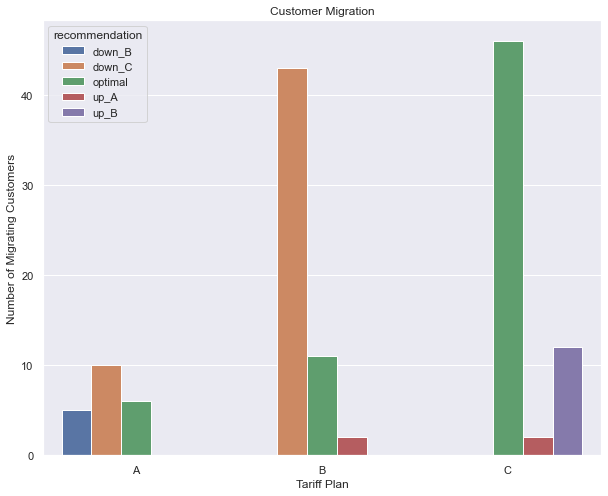

In [66]:
migration_all = active_aggregated_revenue.groupby(['tariff_plan','recommendation']).agg({'user_id':'nunique'}).reset_index()
ax = sns.barplot(x='tariff_plan', y='user_id', hue='recommendation', data=migration_all)
ax.set(title='Customer Migration', xlabel='Tariff Plan', ylabel='Number of Migrating Customers')
plt.show()


The largest number of transitions should occur from tariff B to tariff C, while the smallest number of customers should upgrade to tariff A.

Let's try to find the decrease in revenue for active customers and see if we can reduce the revenue decline by excluding outliers for customers with overly active operators.

In [67]:
active_aggregated_revenue['current_tariff_profit'] = active_aggregated_revenue.apply(current_tariff_profit, axis=1)
active_aggregated_revenue['best_tariff_profit'] = active_aggregated_revenue.apply(best_tariff_profit, axis=1)
print(f"Total revenue from active customers is: {active_aggregated_revenue['current_tariff_profit'].sum():.2f}")
print(f"Revenue decline will be: {(active_aggregated_revenue['current_tariff_profit'].sum() - active_aggregated_revenue['best_tariff_profit'].sum()):.2f}")
print(f"Revenue decline percentage: {100 - (active_aggregated_revenue['best_tariff_profit'].sum() / active_aggregated_revenue['current_tariff_profit'].sum()) * 100:.2f}%")


Total revenue from active customers is: 1258295.60
Revenue decline will be: 169583.90
Revenue decline percentage: 13.48%


In [68]:
anomal_operators = anomal_calls['operator_id'].unique()
anomal_users = df.query("operator_id in @anomal_operators")['user_id'].unique()
normal_active_aggregated_revenue = active_aggregated_revenue.query('user_id not in @anomal_users')


In [69]:
normal_active_aggregated_revenue['current_tariff_profit'] = normal_active_aggregated_revenue.apply(current_tariff_profit, axis=1)
normal_active_aggregated_revenue['best_tariff_profit'] = normal_active_aggregated_revenue.apply(best_tariff_profit, axis=1)
print(f"Total revenue from active customers is: {normal_active_aggregated_revenue['current_tariff_profit'].sum():.2f}")
print(f"Revenue decline will be: {(normal_active_aggregated_revenue['current_tariff_profit'].sum() - normal_active_aggregated_revenue['best_tariff_profit'].sum()):.2f}")
print(f"Revenue decline percentage: {100 - (normal_active_aggregated_revenue['best_tariff_profit'].sum() / normal_active_aggregated_revenue['current_tariff_profit'].sum()) * 100:.2f}%")


Total revenue from active customers is: 1098052.40
Revenue decline will be: 158656.75
Revenue decline percentage: 14.45%


When attempting to remove outliers, we decreased the total revenue amount and the revenue decline in absolute terms. However, in percentage terms, the revenue decline became larger. Therefore, in order to determine the method of reducing revenue, we will need to investigate the outliers and study their nature.

In [70]:
aggregated_revenue_mean = revenue_df.groupby(['user_id','tariff_plan']).agg({'tariff_A':'mean',
                                                  'tariff_B':'mean',
                                                  'tariff_C':'mean'}).reset_index()
aggregated_revenue_mean['best_tariff_plan'] = aggregated_revenue_mean[['tariff_A', 'tariff_B', 'tariff_C']].idxmin(axis=1)

aggregated_revenue_mean['best_tariff_plan'] = aggregated_revenue_mean['best_tariff_plan'].replace('tariff_A', 'A')
aggregated_revenue_mean['best_tariff_plan'] = aggregated_revenue_mean['best_tariff_plan'].replace('tariff_B', 'B')
aggregated_revenue_mean['best_tariff_plan'] = aggregated_revenue_mean['best_tariff_plan'].replace('tariff_C', 'C')
aggregated_revenue_mean['current_tariff_profit'] = aggregated_revenue_mean.apply(current_tariff_profit, axis = 1)
aggregated_revenue_mean['best_tariff_profit'] = aggregated_revenue_mean.apply(best_tariff_profit, axis = 1)
aggregated_revenue_mean

,user_id,tariff_plan,tariff_A,tariff_B,tariff_C,best_tariff_plan,current_tariff_profit,best_tariff_profit
0,166377,B,4732.066667,3691.700000,4018.000000,B,3691.700000,3691.700000
1,166391,C,4050.000000,2150.000000,1300.000000,C,1300.000000,1300.000000
2,166392,C,4100.000000,2300.000000,1600.000000,C,1600.000000,1600.000000
3,166399,C,4050.000000,2150.000000,1300.000000,C,1300.000000,1300.000000
4,166405,B,6213.733333,6351.483333,8317.666667,A,6351.483333,6213.733333
...,...,...,...,...,...,...,...,...
281,168583,B,4075.000000,2225.000000,1450.000000,C,2225.000000,1450.000000
282,168598,C,4050.000000,2150.000000,1300.000000,C,1300.000000,1300.000000
283,168601,C,4271.600000,2596.800000,2172.000000,C,2172.000000,2172.000000
284,168603,B,4056.900000,2161.500000,1323.000000,C,2161.500000,1323.000000


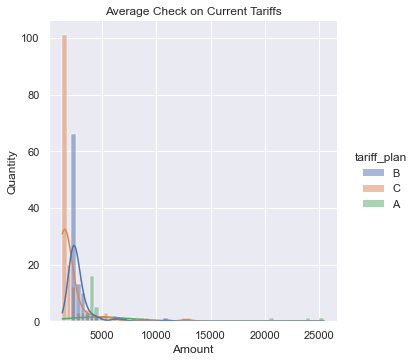

In [71]:
sns.displot(data=aggregated_revenue_mean, x='current_tariff_profit', hue='tariff_plan', kde=True).set(
    title='Average Check on Current Tariffs',
    ylabel='Quantity',
    xlabel='Amount'
);


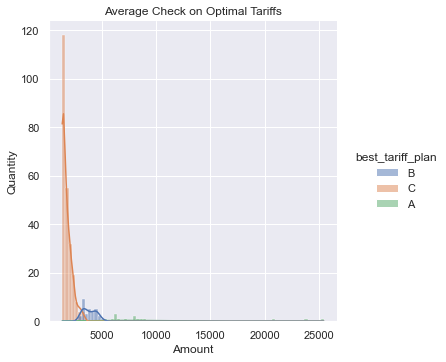

In [72]:
sns.displot(data=aggregated_revenue_mean, x='best_tariff_profit', hue='best_tariff_plan', kde=True).set(
    title='Average Check on Optimal Tariffs',
    ylabel='Quantity',
    xlabel='Amount'
);



It can be seen how the main revenue will affect the decrease in the average check and the increase in the number of customers on tariff C, as well as reduce the number of customers on tariffs A and B, but increase their average check.

In [73]:
mean_tariffs_revenue = aggregated_revenue_mean.groupby('tariff_plan').agg({'current_tariff_profit':'mean',
                                                                           'user_id':'count'}).rename(columns = {'user_id':'current_users'}).reset_index()

In [74]:
mean_tariffs_revenue = mean_tariffs_revenue.merge(aggregated_revenue_mean.groupby('best_tariff_plan').agg({'best_tariff_profit':'mean',
                                                                           'user_id':'count'}).reset_index().rename(columns = {'best_tariff_plan':'tariff_plan','user_id':'best_tariff_users'}), on = 'tariff_plan') 
mean_tariffs_revenue

,tariff_plan,current_tariff_profit,current_users,best_tariff_profit,best_tariff_users
0,A,6529.144086,31,10355.271111,15
1,B,2783.740167,100,3828.236559,31
2,C,2090.631183,155,1697.956250,240


## Statistical data analysis

### Hypothesis №1

**Null Hypothesis:** The revenue of active and inactive customers does not differ.

**Alternative Hypothesis:** The revenue of active and inactive customers differs.

The significance level (alpha) is set at five percent, 0.05.


In [75]:
unactive_clients_revenue = aggregated_revenue.query('user_id not in @active_clients_list')['current_tariff_profit']
active_clients_revenue = aggregated_revenue.query('user_id in @active_clients_list')['current_tariff_profit']

In [76]:
unactive_clients_revenue.describe()

count    149.000000  
mean     3713.651678 
std      2459.642382 
min      1300.000000 
25%      2198.000000 
50%      2900.000000 
75%      4457.500000 
max      16134.400000
Name: current_tariff_profit, dtype: float64

In [77]:
active_clients_revenue.describe()

count    137.000000  
mean     9184.639416 
std      8631.063572 
min      2994.000000 
25%      4929.500000 
50%      6987.000000 
75%      10336.000000
max      76420.800000
Name: current_tariff_profit, dtype: float64

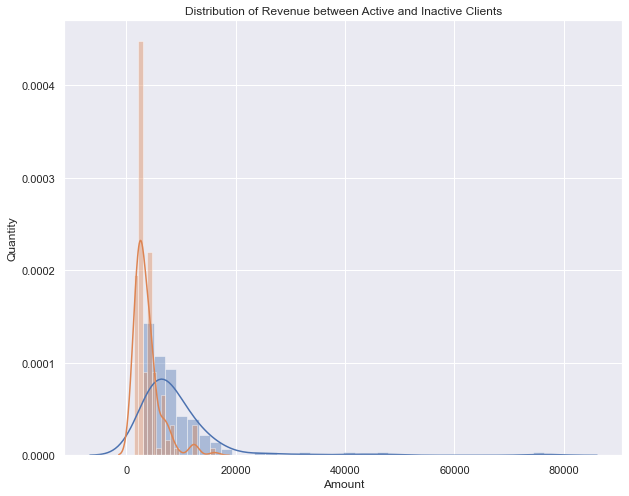

In [78]:
sns.distplot(active_clients_revenue, kde=True)
sns.distplot(unactive_clients_revenue, kde=True).set(
    title='Distribution of Revenue between Active and Inactive Clients',
    ylabel='Quantity',
    xlabel='Amount'
);


The values of the samples are normally distributed

In [79]:
alpha = 0.05

results = st.ttest_ind(
    unactive_clients_revenue, 
    active_clients_revenue)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")


p-value: 1.3832482247030934e-12
We reject the null hypothesis.


The current revenue of active and inactive clients differs. We reject the null hypothesis in favor of the alternative.

### Hypothesis №2
**Null hypothesis**: The revenue of customers on tariff A and B does not differ

**Alternative hypothesis:** The revenue of customers on tariff A and B differs.

The significance level (alpha) is set at five percent, which is equivalent to 0.05.


In [80]:
tariff_A_revenue = aggregated_revenue.query('tariff_plan == "A"')['current_tariff_profit']
tariff_B_revenue = aggregated_revenue.query('tariff_plan == "B"')['current_tariff_profit']

In [81]:
tariff_A_revenue.describe()

count    31.000000   
mean     15148.464516
std      14595.233670
min      4050.000000 
25%      8621.300000 
50%      12450.000000
75%      13718.900000
max      76420.800000
Name: current_tariff_profit, dtype: float64

In [82]:
tariff_B_revenue.describe()

count    100.00000  
mean     6333.83300 
std      3950.66782 
min      2150.00000 
25%      4341.25000 
50%      6450.75000 
75%      7582.36250 
max      33014.15000
Name: current_tariff_profit, dtype: float64

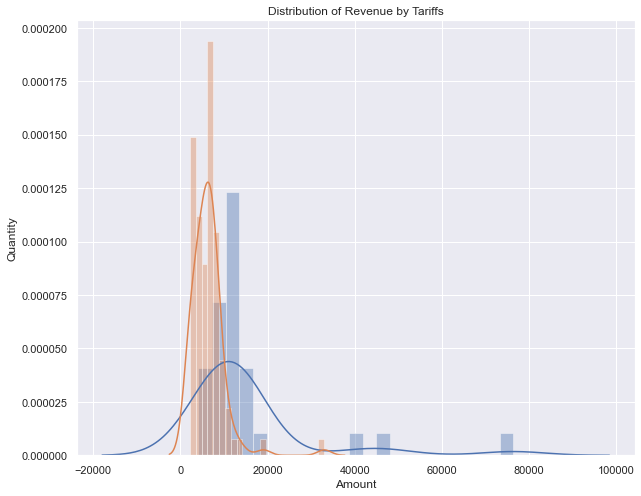

In [83]:
sns.distplot(tariff_A_revenue, kde=True)
sns.distplot(tariff_B_revenue, kde=True).set(
    title='Distribution of Revenue by Tariffs',
    ylabel='Quantity',
    xlabel='Amount'
);


Values of samples are normally distributed

In [84]:
alpha = 0.05

results = st.ttest_ind(
    tariff_A_revenue, 
    tariff_B_revenue)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")


p-value: 2.2800567670735054e-07
We reject the null hypothesis.


The current average revenue of customers on tariff A and B differs. We reject the null hypothesis in favor of the alternative

# Conclusion

### 1. Research Process
For the analysis, two datasets were provided - one containing call records and the other with customer data. During the research process, data preprocessing was conducted, outliers were identified, all possible tariffs for each subscriber were calculated, optimal tariffs were determined, and potential migration and revenue decline were analyzed.

### 2. Calculation of Total Revenue
The total revenue from all customers is 1,811,629.70 rubles, and the revenue decline upon migration is 270,326.30 rubles.

Revenue decline percentage: 0.15

### 3. Calculation of Revenue from Active Customers
The total revenue from active customers is 1,098,052.40 rubles, and the revenue decline upon migration is 158,656.75 rubles.

Revenue decline percentage: 0.14

### 4. Customer Migration
Out of 66 active customers on their current tariffs, 55 will transition to tariff C with a downgrade, 13 will upgrade to tariff B, 5 will downgrade to tariff B, and 3 will upgrade to tariff A. The most popular tariff for migration is C.

### 5. Revenue Loss Minimization Options
Revenue loss upon migration to optimal tariffs is inevitable, but before providing recommendations, it is necessary to address the issue of abnormally active operators who made numerous calls per day. If their data is excluded from the billing, they should be removed.

### 6. Average Checks Before and After Migration
Upon migration to tariffs A and B, the average checks increase, but the number of subscribers decreases, while on tariff C, it is the opposite.

**Before migration, the average checks are as follows:**
- Tariff A: Average check - 6,529.14 rubles, Number of users - 31
- Tariff B: Average check - 2,783.74 rubles, Number of users - 100
- Tariff C: Average check - 2,090.63 rubles, Number of users - 155

**After migration, the situation changes:**
- Tariff A: Average check - 10,355.27 rubles, Number of users - 15
- Tariff B: Average check - 3,828.23 rubles, Number of users - 31
- Tariff C: Average check - 1,697.95 rubles, Number of users - 240

### 7. Statistical Analysis
During the statistical analysis, it was determined that the revenue of active and inactive customers differs, as well as the revenue between customers on tariffs A and B.

